# **Data Visualization**
---

## Objective

- Answer business requirement 1:
    * The client wants to make sure that the animal images are visually distinguishable from one another.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 450x450) in each labelled folder, showing a close-up of the pet's face

## Outputs

- Image shape embeddings pickle file
- Mean and variability of images per label plot
- Plot to distinguish the contrast between individual pets
- Code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard

---

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil
import random

sns.set_style("white")


### Set the correct working directory

In [2]:
# Check the current working directory; os.chdir to change working directory if needed
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the paths to the input and output folders

In [8]:
# Save path names for each directory
full_dataset_path = os.path.normpath(os.path.join(cwd, 'inputs/datasets/pets'))

output_path = os.path.join(cwd, 'outputs')
train_path = os.path.join(full_dataset_path, 'train')
test_path = os.path.join(full_dataset_path, 'test')
validation_path = os.path.join(full_dataset_path, 'validation')



### Create style for highlighting errors and warnings

In [5]:
from colorama import Fore, Style

# Error notification style
def print_err(message):
    print(f'{Fore.RED}ERROR:{Style.RESET_ALL}\n{message}')

# Warning notification style
def print_warn(message):
    print(f'{Fore.YELLOW}WARNING:{Style.RESET_ALL}\n{message}')

---
## **Visualize the data**
---

### Save image size in pickle file

Since we have cleaned the data in the 'Data Collection' step and made sure that all images have the same size and aspect ratio, we will simply save the input image shape in a pickle file.

(450, 450, 3)


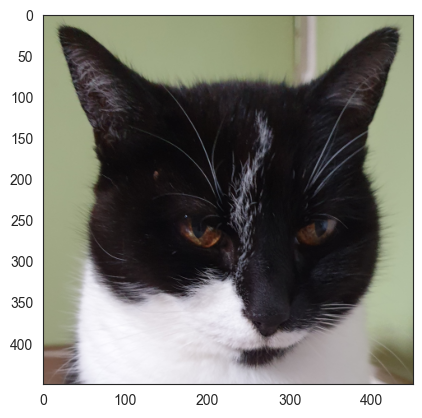

In [14]:
# Check random image shape
rnd_label = random.choice(os.listdir(train_path))
img = imread(os.path.join(train_path, rnd_label, random.choice(os.listdir(os.path.join(train_path, rnd_label)))))
# Check original image shape
img_shape = img.shape
print(img_shape)
if img_shape == (450, 450, 3):
    joblib.dump(value=img_shape, filename=f"{output_path}/img_shape.pkl")
    
plt.imshow(img)
plt.show()

### Function to load all images into an array

In [15]:
# Load all images from specified folder, resize them, save them as np array in X and save their labels in y
def save_images_in_array(path, size=(200, 200), label=True):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    if label:
        for label in os.listdir(path):
            img_list = os.listdir(os.path.join(path, label))
            for img_name in img_list:
                img = image.load_img(os.path.join(path, label, img_name))
                img_resized = image.img_to_array(img.resize(size, resample=Image.LANCZOS))
                if img_resized.max() > 1:
                    img_resized = img_resized / 255
                new_shape = (-1, size[0], size[1], 3)
                X = np.append(X, img_resized).reshape(new_shape)
                y = np.append(y, label)
    else:
        label = 'unknown'
        img_list = os.listdir(path)
        for img_name in img_list:
            img = image.load_img(os.path.join(path, img_name))
            img_resized = image.img_to_array(img.resize(size, resample=Image.LANCZOS))
            if img_resized.max() > 1:
                img_resized = img_resized / 255
            new_shape = (-1, size[0], size[1], 3)
            X = np.append(X, img_resized).reshape(new_shape)
            y = np.append(y, label)
            
    # Shuffle the training set
    train_set = list(zip(y, X))
    random.shuffle(train_set)
    y_shuffled, X_shuffled = list(map(list, zip(*train_set)))
    X = np.array(X_shuffled, dtype='float')
    y = np.array(y_shuffled, dtype='object')
    
    return X, y

            

In [16]:
# Load all training images into an array

X_train, y_train = save_images_in_array(train_path)

### Create and show average images for each label

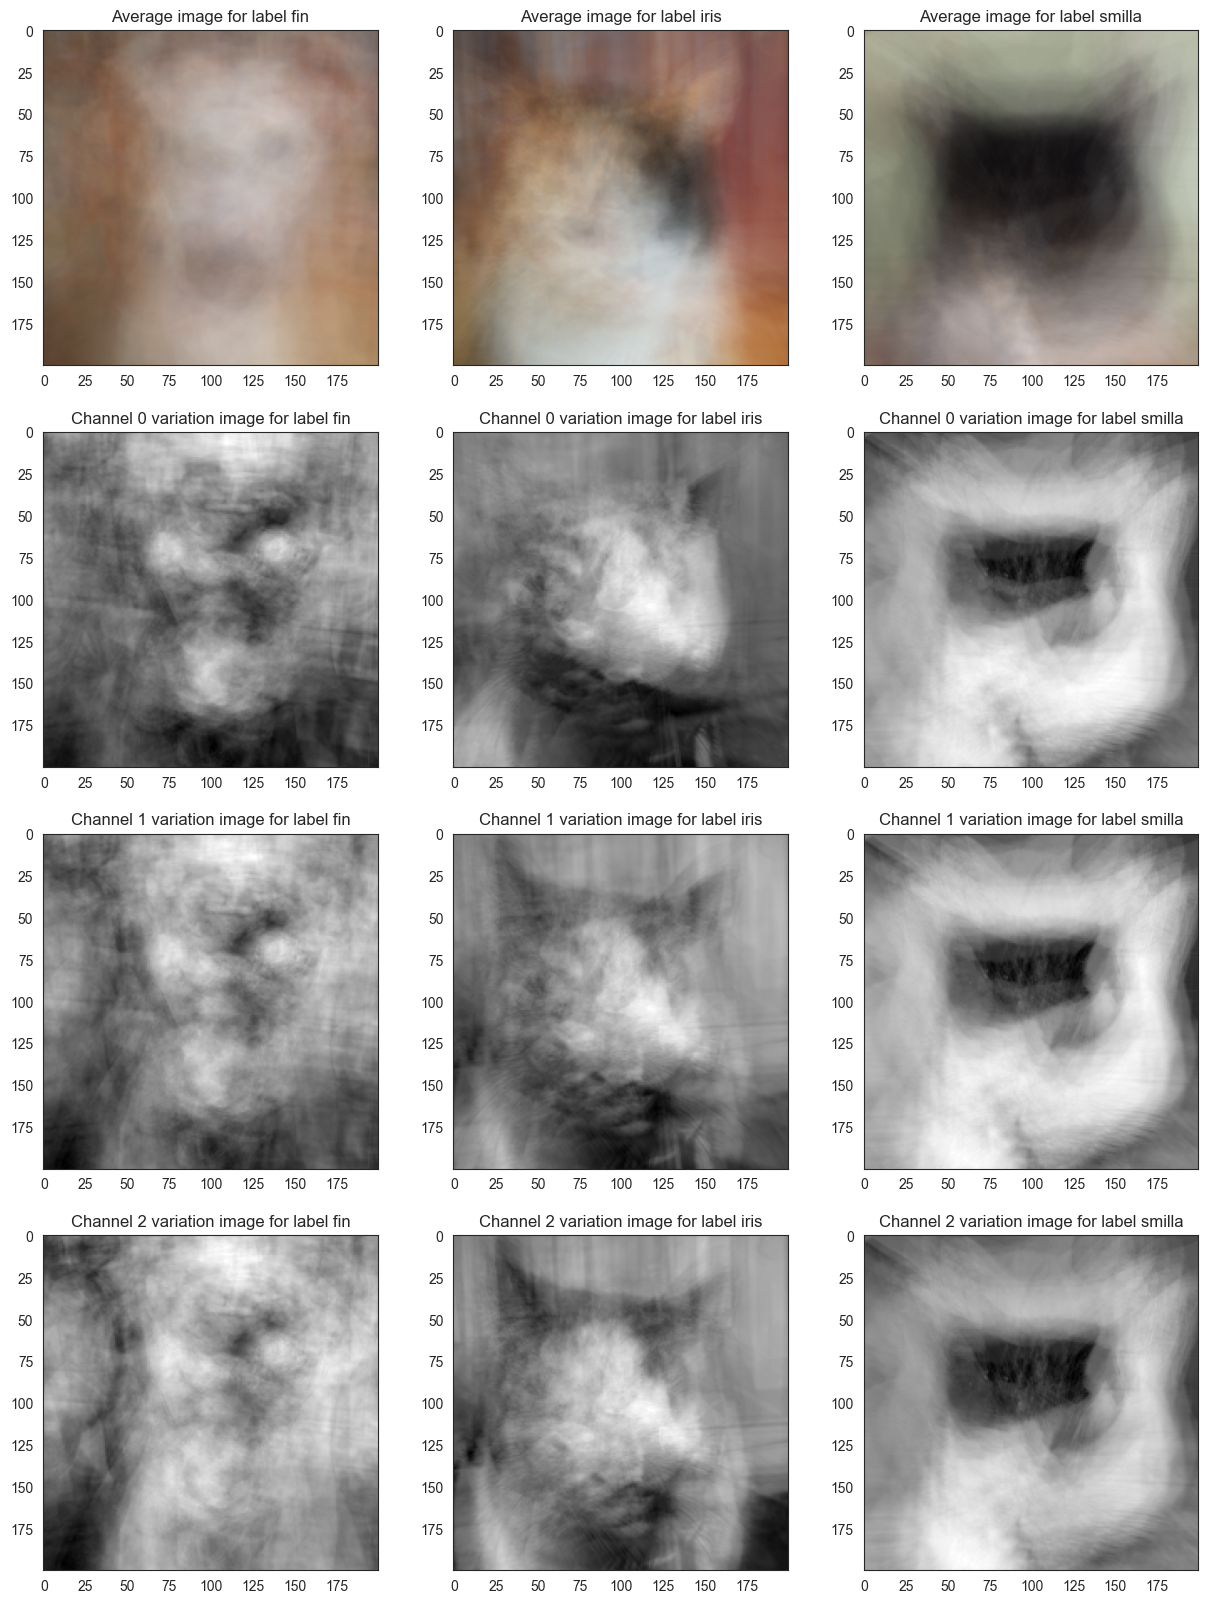

Difference between fin and iris:


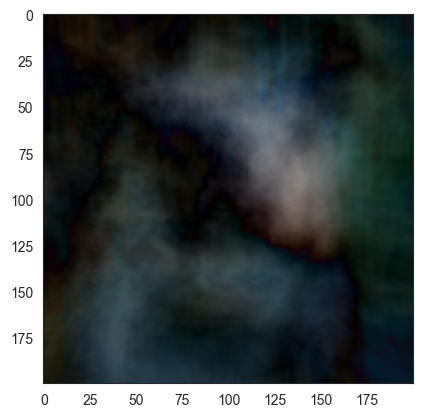

Difference between fin and smilla:


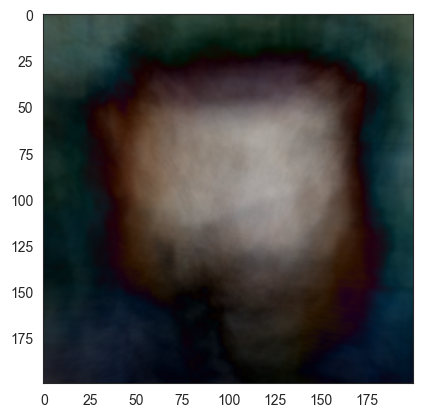

Difference between iris and smilla:


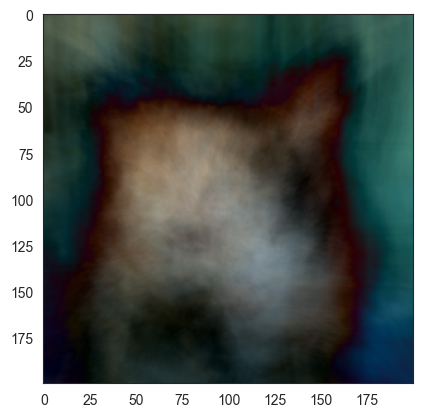

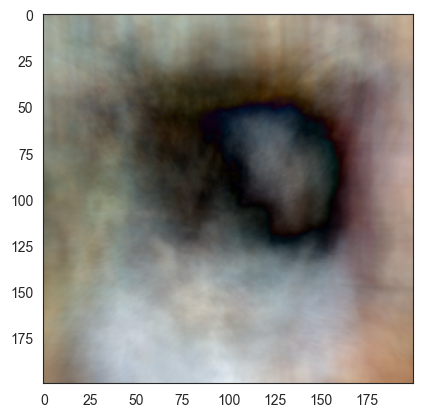

In [48]:

import itertools

def show_averages(X, y):
    
    label_imgs = {'Means': {}, 'Vars': {}}
    labels = np.unique(y)
    
    for label in labels:

        y = y.reshape(-1, 1, 1)
        bool_mask = np.any(y == label, axis=1).reshape(-1)
        arr = X[bool_mask]

        X_mean = np.mean(arr, axis=0)
        label_imgs['Means'][label] = X_mean
        #print(X_mean)
        # plt.imshow(X_mean)
        # plt.show()
        label_imgs['Vars'][label] = {}
        for channel in [0, 1, 2]:
            X_dev = np.std(arr[..., channel], axis=0)
            label_imgs['Vars'][label][channel] = X_dev

    means = label_imgs['Means']
    vars = label_imgs['Vars']
    fig, axes = plt.subplots(nrows=4, ncols=len(labels), figsize=(len(labels)*5, 20))
    for idx, label in enumerate(labels):
        axes[0][idx].set_title(f"Average image for label {label}")
        axes[0][idx].imshow(means[label], cmap='gray')

    for ch in [0, 1, 2]:
        for idx, label in enumerate(labels):
            axes[ch+1][idx].set_title(f"Channel {ch} variation image for label {label}")
            axes[ch+1][idx].imshow(vars[label][ch], cmap='gray')
    
    # TODO: save figure
    plt.show()
    
    for combo in itertools.combinations(labels, 2):
        print(f'Difference between {combo[0]} and {combo[1]}:')
        plt.imshow(abs(means[combo[0]] - means[combo[1]]))
        plt.show()
        
    differences = abs(means[labels[0]] - means[labels[1]] - means[labels[2]])
    plt.imshow(differences)
    plt.show()

show_averages(X_train, y_train)
# show_averages(X_train, y_train, 'iris')
# show_averages(X_train, y_train, 'smilla')


# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
# axes[0].set_title(f"Average image for label {label_to_display}")
# axes[0].imshow(avg_img, cmap='gray')
